---

# CSCI 3202, Fall 2022
# Homework 2: MDP & Reinforcement Learning
# Due: Friday September 9, 2022 at 6:00 PM

<br> 

### Your name: Xinyi Lu

<br> 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. 
* In this world, $L$ is always an even value.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
How many states would be in the discrete state space if $L=2$? Explain your reasoning.

*Your answer here:* 27. 
For each direction, there are 3 possible values: 0, 1, 2. 
Since there are 3 directions, we will get 3 x 3 x 3 = 27 for the number of states. 

#### Part B
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to include transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part C, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [2]:
# Solution:
class MDPLanding:
    def __init__(self, L):
        self.states = []
        self.terminal_states = {}
        self.default_reward = -0.01
        self.discount = 0.999
        for x in range(L+1):
            for y in range(L+1):
                if (x == L/2) and (y == L/2):
                    self.terminal_states[(x, y, 0)] = 1
                else:
                    self.terminal_states[(x, y, 0)] = -1
                for z in range(L+1):
                    new = (x, y, z)
                    self.states.append(new)
        self.all_actions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
    
    def actions(self, state):
        # return a list of all actions available from the given state
        current_x = state[0]
        current_y = state[1]
        current_z = state[2]
        if current_z == 0:
            return []
        new_actions = self.all_actions.copy()
        L = max([x for (x, y, z) in self.states])
        if current_x == L: #if current x is the maximum, remove (1, 0, 0) action
            new_actions.remove((1, 0, 0))
        elif current_x == 0:
            new_actions.remove((-1, 0, 0))
        if current_y == L: #if current y is the maximum, remove (0, 1, 0) action
            new_actions.remove((0, 1, 0))
        elif current_y == 0:
            new_actions.remove((0, -1, 0))
        if current_z == L:
            new_actions.remove((0, 0, 1))
        elif current_z == 0:
            new_actions.remove((0, 0, -1))
        return new_actions
    
    def reward(self, state):
        # return the reward for the given state
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.default_reward
    
    def result(self, state, action):
        # return the resulting state of doing the given action in the given state
        # check if state is terminal state
        if (state in self.terminal_states) or (action is None) :
            return state
        new_x = state[0] + action[0]
        new_y = state[1] + action[1]
        new_z = state[2] + action[2]
        return (new_x, new_y, new_z)

In [3]:
a = MDPLanding(2)
a.result((0, 1, 1), (0, 0, 1))

(0, 1, 2)

In [4]:
for state in a.terminal_states:
    print(state)

(0, 0, 0)
(0, 1, 0)
(0, 2, 0)
(1, 0, 0)
(1, 1, 0)
(1, 2, 0)
(2, 0, 0)
(2, 1, 0)
(2, 2, 0)


#### Part C
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case.

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [5]:
import random
def expected_utility(a, s, U, mdp):
    #the expected utility of doing a in state s, according to the MDP and U
    s2 = mdp.result(s, a)
    return U[s2]

def policy_evaluation(policy, utility, mdp):
    # do a handful of value iteration updates of the input utility, under the given policy
    for s1 in policy:
        action = policy[s1]
        s2 = mdp.result(s1, action)
        r = mdp.reward(s2)
        utility[s2] = r + mdp.discount*utility[s1]
    return utility# updated utility

def policy_iteration(mdp):
    U = {s: 0 for s in mdp.states} # initialize utility for all states
#     pi = {s: random.choice(mdp.actions(s)) for s in mdp.states if mdp.actions(s) != []} # initialize a policy for each state, being a random action
    pi = {s: random.choice(mdp.actions(s)) if mdp.actions(s) != [] else None for s in mdp.states}
    # iterate:
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            if (mdp.actions(s) == []):
                continue
            a = max(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp)) # among the possible actions, which yields the maximum expected utility?
            if a != pi[s]: #if the best action choice is not currently the policy for s, update it
                pi[s] = a
                unchanged = False #if non of the actions have changed for any state, policy does not change
        # if no policy values are changed, break!
        if unchanged:
            return pi

In [6]:
b = MDPLanding(4)
optimal = policy_iteration(b)

In [7]:
print(optimal[(2, 2, 1)])
print(optimal[(0, 2, 1)])
print(optimal[(2, 0, 1)])

(0, 0, -1)
(1, 0, 0)
(1, 0, 0)


The policy for 
(2, 2, 1): (0, 0, -1) - This is reasonable as moving Down by 1 unit results in the state (2, 2, 0), which is the landing pad.

(0, 2, 1): (1, 0, 0) - This is reasonable as moving East by 1 unit results in the state (1, 2, 1), which brings it closer to the landing pad. 

(2, 0, 1): (1, 0, 0) - This is not reasonable as moving East by 1 unit results in the state (3, 0, 1), which is not optimal as the landing pad has an x value of 2. So, it would be more optimal to move North or Down. 

#### Part D
Provide an example of a non-deterministic transition that could be included in your code in Part C. Describe the function. How would you modify your code to handle a non-deterministic transition function?

It can be included in the expected_utility function. The new expected_utility function will return the sum of [p*U[s1] for (p, s1) in mdp.T(s, a)]. We will need to add another method in the MDPLanding class, T(state, action) that will return a list of tuples containing probability and transition states. 

#### Part E
Describe the main differences between **policy iteration** and **value iteration**? How would your code change in Part C to convert it to **value iteration**?

Value iteration keeps track of utilities and terminates when updates < threshold. Policy iteration also stores policies and terminates when no policy changes. 

Replace policy with the value function. Instead of having a policy evaluation and update, in the value iteration, we take a maximum over the utility function for all possible actions. 

#### Part F

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [8]:
# Solution:
# Q-learning: estimate the value of doing action a in state s
# Q(s, a) = expected value of doing action a in state s
# return learned Q values associated with each state-action pair
# cumulative reward for each training trial
from itertools import combinations
def Greedy(mdp, epsilon, state, q, rewards):
    prob = random.random()
    if prob < epsilon:
        return random.choice(mdp.actions(state))
    return max(mdp.actions(state), key=lambda a: q[(state, a)])

def QLearning(mdp, num_episodes, learning_rate, epsilon):
    states = mdp.states
    states_actions = []
    for s in states:
        actions = mdp.actions(s)
        if actions != []:
            for a in actions:
                states_actions.append((s, a))
        else:
            states_actions.append((s, ()))
                
    #init policy, Q, rewards            
    q = dict(zip(states_actions, [0]*len(states_actions)))
    rewards = {s: 0 for s in mdp.states}
     
    all_rewards = []
    for i in range(num_episodes):
        s1 = random.choice(states)
        cum_rewards = 0
        
        for j in range(50):
            if s1 in mdp.terminal_states:
                rewards[s1] += mdp.terminal_states[s1]
                cum_rewards += (mdp.discount**j)*mdp.terminal_states[s1]

                break
            else:
                a1 = Greedy(mdp, epsilon, s1, q, rewards)
                rewards[s1] += mdp.reward(s1)
                cum_rewards += (mdp.discount**j)*mdp.reward(s1)
                s2 = mdp.result(s1, a1)
                if mdp.actions(s2) == []:
                    a2 = ()
                else:
                    a2 = max(mdp.actions(s2), key = lambda a: q[(s2, a)] - q[(s1, a1)])
                Q_new = q[(s1, a1)] + learning_rate*(mdp.reward(s1) + mdp.discount*(q[(s2, a2)] - q[(s1, a1)]))
                q[(s1, a1)] = Q_new
        all_rewards.append(cum_rewards)
    return q, all_rewards  

#### Part G

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

In [17]:
# Solution:
new = MDPLanding(10)
new_q = QLearning(new, 20000, 0.0001, 0.7)

In [18]:
np.mean(new_q[1][-5000:])

-0.53497941979129

In [19]:
ls = []
rewards = new_q[1]
for i in range(0, 20000, 500):
    block_avg = np.mean(rewards[i:i+500])
    ls.append(block_avg)    

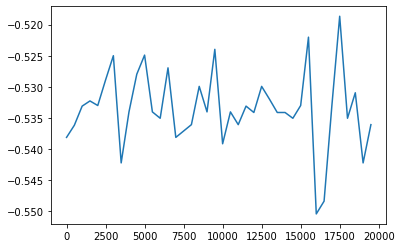

In [20]:
x_values = np.arange(0, 20000, 500)
plt.plot(x_values, ls)

#### Part H

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

Q1) This is because non-terminal states have a reward of -0.01 and there are 50 steps in a single training episode. Assuming that at the beginning of the training, the drone does not reach terminal state, the reward is approximately -0.01 * 50. 

<br>

Q2) To have rewards > 0.8, 
assuming that the drone lands on the training pad on the 50th step, 
previous rewards + 1 > 0.8
previous rewards > -0.2
-0.01n > -0.2
n < 20. 
This means that the drone should reach the training pad in 20 steps maximum. 
This is difficult for an L = 10 environment as there are 11 x 11 x 11 = 1331 states.